In [22]:
import pyodbc
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# SQL Server Docker container connection info
server = 'localhost,1433'
username = 'sa'
password = 'MyStrongPass123'
driver = '/opt/homebrew/lib/libmsodbcsql.17.dylib'  # Explicit path for macOS/Homebrew

def get_connection(database='master'):
    return pyodbc.connect(
        f"DRIVER={{{driver}}};"
        f"SERVER={server};"
        f"DATABASE={database};"
        f"UID={username};"
        f"PWD={password}"
    )

def run_sql_file(path, conn, autocommit=False):
    with open(path, 'r') as file:
        sql = file.read()

    commands = [cmd.strip() for cmd in sql.split('GO') if cmd.strip()]
    cursor = conn.cursor()

    if autocommit:
        cursor.connection.autocommit = True

    for cmd in commands:
        try:
            cursor.execute(cmd)
            if not autocommit:
                conn.commit()
        except Exception as e:
            print(f"Error in {path}")
            print(f"Query: {cmd[:100]}...")
            print(f"Exception: {e}\n")

    cursor.close()

def drop_database_if_exists(db_name):
    conn = get_connection('master')
    conn.autocommit = True  # <-- This is key
    cursor = conn.cursor()
    try:
        cursor.execute(f"""
            IF EXISTS (SELECT 1 FROM sys.databases WHERE name = '{db_name}')
            BEGIN
                ALTER DATABASE [{db_name}] SET SINGLE_USER WITH ROLLBACK IMMEDIATE;
                DROP DATABASE [{db_name}];
            END
        """)
        print(f"Database '{db_name}' dropped successfully.")
    except Exception as e:
        print(f"Failed to drop database '{db_name}': {e}")
    finally:
        cursor.close()
        conn.close()

In [24]:
print("Checking and dropping existing database and creating new one")
drop_database_if_exists("data_warehouse_prj")

# print("Running architecture.sql...")
# conn_master = get_connection('master')
# run_sql_file("warehouse_quiries/architecture.sql", conn_master, autocommit=True)
# conn_master.close()

Checking and dropping existing database and creating new one
Database 'data_warehouse_prj' dropped successfully.


In [25]:
# Step 1: Running architecture.sql from master 
print("Running architecture.sql...")
conn_master = get_connection('master')
run_sql_file("warehouse_quiries/architecture.sql", conn_master, autocommit=True)
conn_master.close()

# Step 2: Connecting to the newly created database
print("Connecting to data_warehouse_prj...")
conn_dw = get_connection('data_warehouse_prj')

# Step 3: Runing all remaining SQL scripts in order
sql_files = [
    "warehouse_quiries/bronze/ddl_bronze.sql",
    "warehouse_quiries/silver/ddl_silver.sql",
    "warehouse_quiries/bronze/load_bronze.sql",
    "warehouse_quiries/silver/proc_load_silver.sql",
    "warehouse_quiries/gold/ddl_gold.sql",
    "warehouse_quiries/Inspect/test_silver.sql",
    "warehouse_quiries/Inspect/test_gold.sql"
]

for file_path in sql_files:
    print(f"Running {file_path}...")
    run_sql_file(file_path, conn_dw)

conn_dw.close()
print("All SQL scripts executed successfully.")

Running architecture.sql...
Connecting to data_warehouse_prj...
Running warehouse_quiries/bronze/ddl_bronze.sql...
Running warehouse_quiries/silver/ddl_silver.sql...
Running warehouse_quiries/bronze/load_bronze.sql...
Running warehouse_quiries/silver/proc_load_silver.sql...
Running warehouse_quiries/gold/ddl_gold.sql...
Running warehouse_quiries/Inspect/test_silver.sql...
Running warehouse_quiries/Inspect/test_gold.sql...
All SQL scripts executed successfully.


In [26]:
def run_stored_procs_in_order():
    conn = get_connection('data_warehouse_prj')
    cursor = conn.cursor()

    # ETL and gold layer setup
    etl_procs = [
        "sp_create_bronze_tables",
        "sp_create_silver_tables",
        "bronze.load_bronze",
        "silver.load_silver",
        "sp_create_gold_views"
    ]

    for proc in etl_procs:
        try:
            print(f"Running procedure: {proc}...")
            cursor.execute(f"EXEC {proc}")
            conn.commit()
        except Exception as e:
            print(f"Error running procedure {proc}: {e}")

    cursor.close()

    # Run test procs and show result sets
    test_procs = ["sp_test_silver", "sp_test_gold"]
    for test_proc in test_procs:
        print(f"\nRunning test: {test_proc}")
        try:
            df = pd.read_sql(f"EXEC {test_proc}", conn)
            if df.empty:
                print("✔ No issues found.")
            else:
                print(f"⚠ Issues found in {test_proc}:")
                display(df)
        except Exception as e:
            print(f"Error running test {test_proc}: {e}")

    conn.close()
    print("All procedures and validations completed.")


print("Running all ETL and QC stored procedures...")
run_stored_procs_in_order()

Running all ETL and QC stored procedures...
Running procedure: sp_create_bronze_tables...
Running procedure: sp_create_silver_tables...
Running procedure: bronze.load_bronze...
Running procedure: silver.load_silver...
Running procedure: sp_create_gold_views...

Running test: sp_test_silver


/var/folders/cy/wgjwzh1n2972lh_2nybh6rhc0000gn/T/ipykernel_24151/1250296766.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"EXEC {test_proc}", conn)


✔ No issues found.

Running test: sp_test_gold


/var/folders/cy/wgjwzh1n2972lh_2nybh6rhc0000gn/T/ipykernel_24151/1250296766.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"EXEC {test_proc}", conn)


✔ No issues found.
All procedures and validations completed.


In [27]:
gold_views = [
    "gold.dim_customers",
    "gold.dim_products",
    "gold.fact_sales"
]

dfs = {}
conn_dw = get_connection('data_warehouse_prj')

for view in gold_views:
    df = pd.read_sql(f"SELECT * FROM {view}", conn_dw)
    dfs[view.split('.')[-1]] = df
    print(f"{view}: {len(df)} rows loaded.")

conn_dw.close()

gold.dim_customers: 18484 rows loaded.


/var/folders/cy/wgjwzh1n2972lh_2nybh6rhc0000gn/T/ipykernel_24151/3798837868.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {view}", conn_dw)


gold.dim_products: 295 rows loaded.
gold.fact_sales: 60398 rows loaded.


In [28]:
print(dfs.keys())

dict_keys(['dim_customers', 'dim_products', 'fact_sales'])


In [29]:
def validate_gold(dfs):
    issues = []

    # Check for nulls in foreign keys
    if dfs["fact_sales"]["customer_key"].isnull().sum() > 0:
        issues.append("Some sales records are missing customer_key.")

    if dfs["fact_sales"]["product_key"].isnull().sum() > 0:
        issues.append("Some sales records are missing product_key.")

    # Check for join integrity with dim_customers
    cust_join = dfs["fact_sales"].merge(
        dfs["dim_customers"], on="customer_key", how="left", indicator=True
    )
    if (cust_join["_merge"] != "both").any():
        issues.append("Mismatch detected in fact_sales to dim_customers join.")

    # Check for join integrity with dim_products
    prod_join = dfs["fact_sales"].merge(
        dfs["dim_products"], on="product_key", how="left", indicator=True
    )
    if (prod_join["_merge"] != "both").any():
        issues.append("Mismatch detected in fact_sales to dim_products join.")

    # Check for duplicate keys in dimensions
    if dfs["dim_customers"]["customer_key"].duplicated().any():
        issues.append("Duplicate keys found in dim_customers.")

    if dfs["dim_products"]["product_key"].duplicated().any():
        issues.append("Duplicate keys found in dim_products.")

    if not issues:
        print("Load from gold layer validation passed. No issues found.")
    else:
        print("Gold layer validation failed. Issues detected:")
        for issue in issues:
            print("-", issue)

validate_gold(dfs)

Load from gold layer validation passed. No issues found.


In [30]:
gold_dim_customers = dfs["dim_customers"]
gold_dim_products = dfs["dim_products"]
gold_fact_sales = dfs["fact_sales"]

# Quick sanity check
print("gold_dim_customers:", gold_dim_customers.shape)
print("gold_dim_products:", gold_dim_products.shape)
print("gold_fact_sales:", gold_fact_sales.shape)

gold_dim_customers: (18484, 10)
gold_dim_products: (295, 11)
gold_fact_sales: (60398, 9)


## **EDA**

## Dataset & Schema Overview


In [31]:
def explore_schema(df, name):
    print(f"\n--- Exploring {name} ---")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
    
    # Data types and null statistics
    print("Column Types and Null Counts:")
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'nulls': df.isnull().sum(),
        'null_pct': df.isnull().mean().round(3),
        'n_unique': df.nunique()
    }).sort_values('nulls', ascending=False)
    print(summary)

    # Check for duplicate rows
    dupes = df.duplicated().sum()
    print(f"\nDuplicate Rows: {dupes}")

# Run the overview for each gold view
explore_schema(gold_dim_customers, "gold_dim_customers")
explore_schema(gold_dim_products, "gold_dim_products")
explore_schema(gold_fact_sales, "gold_fact_sales")


--- Exploring gold_dim_customers ---
Shape: 18484 rows × 10 columns

Column Types and Null Counts:
                  dtype  nulls  null_pct  n_unique
birthdate        object     17     0.001      6135
customer_key      int64      0     0.000     18484
customer_id       int64      0     0.000     18484
customer_number  object      0     0.000     18484
first_name       object      0     0.000       670
last_name        object      0     0.000       375
country          object      0     0.000        10
marital_status   object      0     0.000         2
gender           object      0     0.000         3
create_date      object      0     0.000       114

Duplicate Rows: 0

--- Exploring gold_dim_products ---
Shape: 295 rows × 11 columns

Column Types and Null Counts:
                 dtype  nulls  null_pct  n_unique
category        object    295       1.0         0
subcategory     object    295       1.0         0
maintenance     object    295       1.0         0
product_key      int64 

##  Dimension Exploration



--- Customers by Country ---
country
United States     7482
Australia         3591
United Kingdom    1913
France            1810
Germany           1780
Canada            1571
Name: count, dtype: int64


/var/folders/cy/wgjwzh1n2972lh_2nybh6rhc0000gn/T/ipykernel_24151/2372170775.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


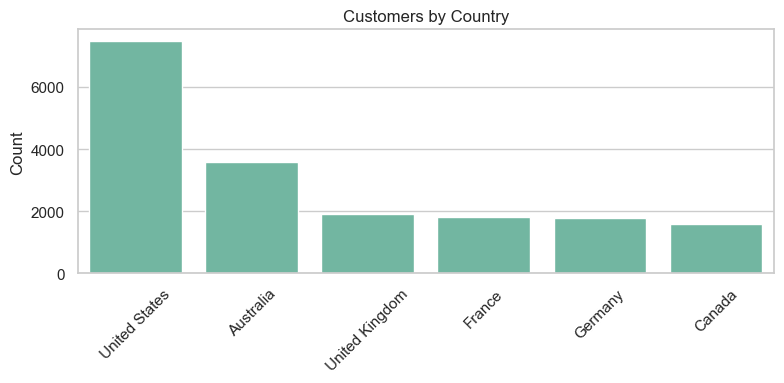


--- Customers by Gender ---
gender
Male      7067
Female    6848
n/a       4569
Name: count, dtype: int64


/var/folders/cy/wgjwzh1n2972lh_2nybh6rhc0000gn/T/ipykernel_24151/2372170775.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


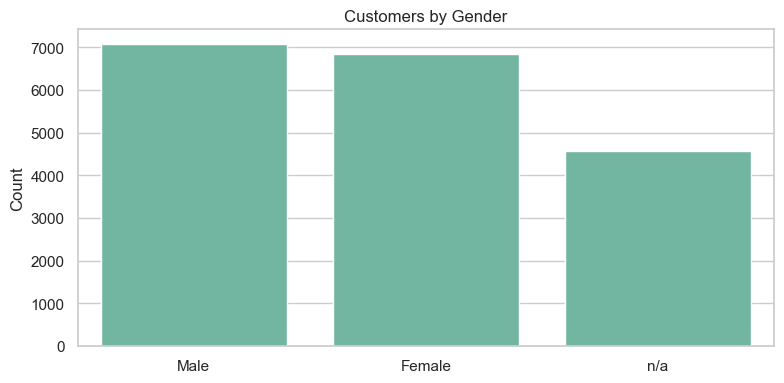


--- Customers by Marital Status ---
marital_status
Married    10011
Single      8473
Name: count, dtype: int64


/var/folders/cy/wgjwzh1n2972lh_2nybh6rhc0000gn/T/ipykernel_24151/2372170775.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


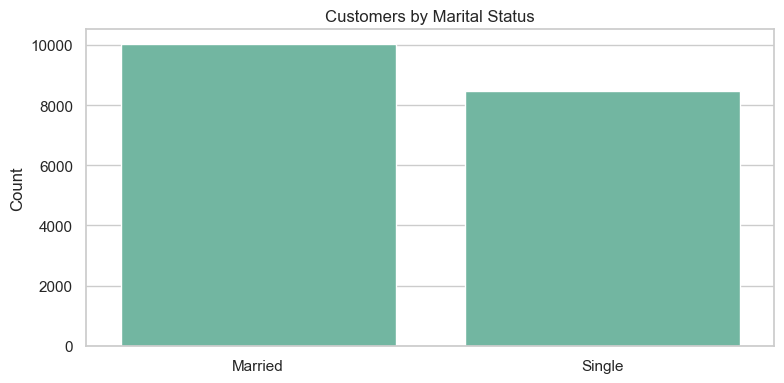

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Styling ---
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

# Use a nice categorical palette
sns.set_palette("Set2")


# --- Generalized Bar Plot Function ---
def plot_bar_clean(df, col, title, rotation=0):
    # Clean values: drop nulls and empty strings
    counts = df[col].dropna()
    counts = counts[counts != ''].value_counts()

    print(f"\n--- {title} ---")
    print(counts)

    # Plot bar chart
    fig, ax = plt.subplots()
    sns.barplot(x=counts.index.astype(str), y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    plt.tight_layout()
    plt.show()


# === Customer Dimension Charts ===
for col in ["country", "gender", "marital_status"]:import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)
sns.set_palette("Set2")


# Country normalization map
country_map = {
    "USA": "United States",
    "US": "United States",
    "United States": "United States",
    "DE": "Germany",
    "": None,
    None: None
}


# Generalized plot function with cleaning
def plot_bar_clean(df, col, title, rotation=0, normalize_map=None):
    series = df[col].dropna().astype(str).str.strip()
    
    # Apply normalization if provided
    if normalize_map:
        series = series.replace(normalize_map)

    # Drop empty strings
    series = series[series != '']
    counts = series.value_counts()

    print(f"\n--- {title} ---")
    print(counts)

    fig, ax = plt.subplots()
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    plt.tight_layout()
    plt.show()


# === Customer Dimension Charts ===
plot_bar_clean(
    gold_dim_customers,
    "country",
    "Customers by Country",
    rotation=45,
    normalize_map=country_map
)

for col in ["gender", "marital_status"]:
    plot_bar_clean(
        gold_dim_customers,
        col,
        f"Customers by {col.replace('_', ' ').title()}",
        rotation=0
    )


# # === Product Dimension Charts ===
# # Normalize column names for mapping
# product_col_map = {col.lower(): col for col in gold_dim_products.columns}

# # Plot safely using actual column names
# for col in ["category", "product_line"]:
#     actual_col = product_col_map.get(col)
#     if actual_col:
#         plot_bar_clean(
#             gold_dim_products,
#             actual_col,
#             f"Products by {actual_col.replace('_', ' ').title()}",
#             rotation=45 if col == "category" else 0
#         )
#     else:
#         print(f"[Warning] Column '{col}' not found in product dataframe.")

# # === Product Dimension Charts ===
# for col in ["category", "product_line"]:
#     plot_bar_clean(
#         gold_dim_products,
#         col,
#         f"Products by {col.replace('_', ' ').title()}",
#         rotation=45 if col == "category" else 0
#     )

<!-- ## Date Range Checks -->

In [33]:
# Convert dates if needed
date_cols = ["order_date", "shipping_date", "due_date"]
for col in date_cols:
    gold_fact_sales[col] = pd.to_datetime(gold_fact_sales[col], errors='coerce')

# Print min/max/nulls for each date column
for col in date_cols:
    print(f"\n--- {col.upper()} ---")
    print("Min:", gold_fact_sales[col].min())
    print("Max:", gold_fact_sales[col].max())
    print("Nulls:", gold_fact_sales[col].isna().sum())


--- ORDER_DATE ---
Min: 2010-12-29 00:00:00
Max: 2014-01-28 00:00:00
Nulls: 19

--- SHIPPING_DATE ---
Min: 2011-01-05 00:00:00
Max: 2014-02-04 00:00:00
Nulls: 0

--- DUE_DATE ---
Min: 2011-01-10 00:00:00
Max: 2014-02-09 00:00:00
Nulls: 0


## Measure Distributions


=== Summary Statistics ===
              Min   Max    Mean  Median  Std Dev  Zeros  Negative
Measure                                                          
PRICE           2  3578  486.04    30.0   928.45      0         0
QUANTITY        1    10    1.00     1.0     0.04      0         0
SALES_AMOUNT    2  3578  486.05    30.0   928.45      0         0


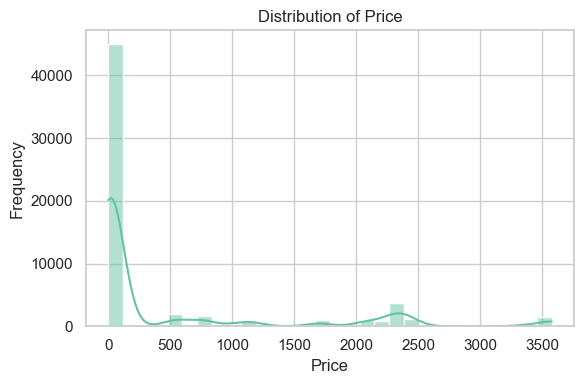

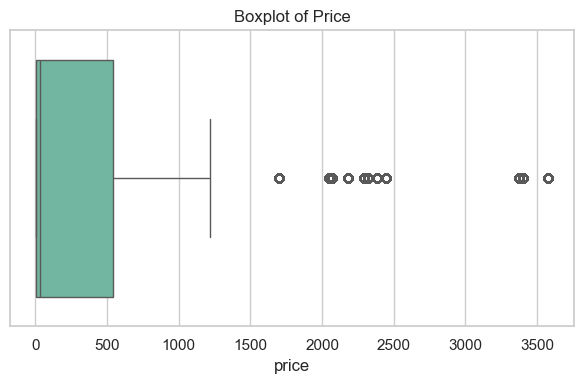

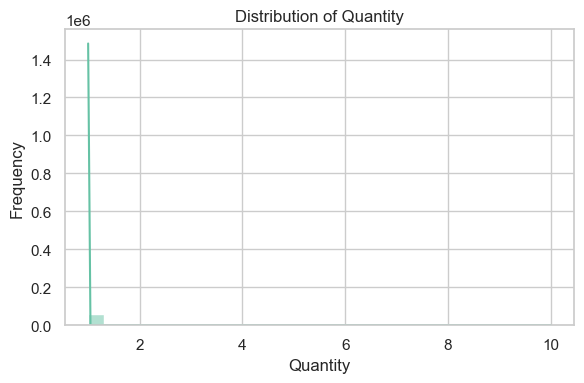

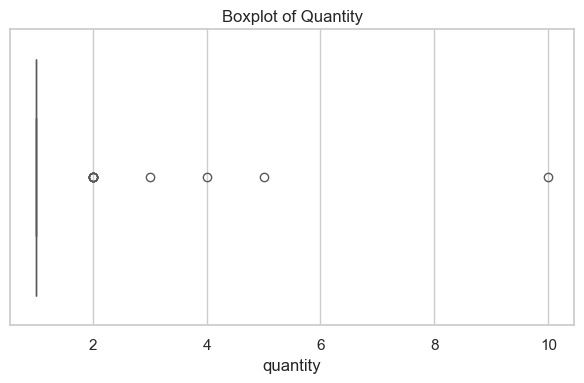

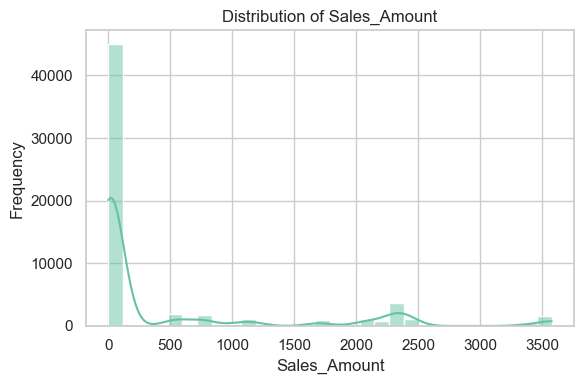

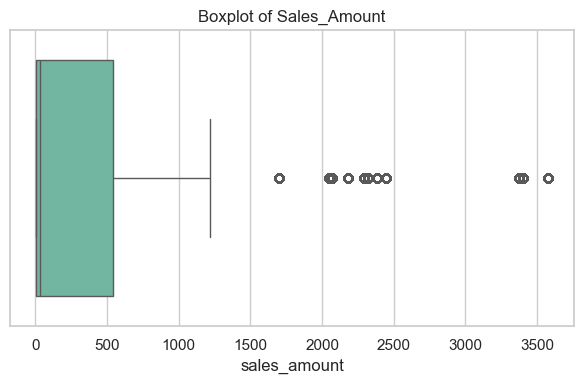

In [34]:

# Settings
measures = ["price", "quantity", "sales_amount"]
sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (6, 4)

# Step 1: Print summary stats first
summary = []

for col in measures:
    summary.append({
        "Measure": col.upper(),
        "Min": gold_fact_sales[col].min(),
        "Max": gold_fact_sales[col].max(),
        "Mean": round(gold_fact_sales[col].mean(), 2),
        "Median": gold_fact_sales[col].median(),
        "Std Dev": round(gold_fact_sales[col].std(), 2),
        "Zeros": (gold_fact_sales[col] == 0).sum(),
        "Negative": (gold_fact_sales[col] < 0).sum()
    })

# Display summary
import pandas as pd
print("\n=== Summary Statistics ===")
print(pd.DataFrame(summary).set_index("Measure"))

# Step 2: Show visualizations per measure
for col in measures:
    # Histogram
    sns.histplot(gold_fact_sales[col], bins=30, kde=True)
    plt.title(f"Distribution of {col.title()}")
    plt.xlabel(col.title())
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Boxplot
    sns.boxplot(x=gold_fact_sales[col])
    plt.title(f"Boxplot of {col.title()}")
    plt.tight_layout()
    plt.show()

## Magnitude Analysis


=== Revenue by Customer ===
count    18484.000000
mean      1588.197901
std       2124.157912
min          2.000000
25%         50.000000
50%        271.500000
75%       2511.000000
max      13294.000000
Name: sales_amount, dtype: float64
Top 5 customers by revenue:
 customer_key
1133    13294
1302    13294
1309    13268
1132    13265
1301    13242
Name: sales_amount, dtype: int64

=== Revenue by Product ===
count    1.300000e+02
mean     2.258173e+05
std      3.468187e+05
min      2.430000e+03
25%      2.541375e+04
50%      5.543700e+04
75%      3.075900e+05
max      1.373454e+06
Name: sales_amount, dtype: float64
Top 5 products by revenue:
 product_key
122    1373454
121    1363128
123    1339394
125    1301029
120    1294854
Name: sales_amount, dtype: int64

=== Revenue by Category ===
Series([], Name: sales_amount, dtype: int64)


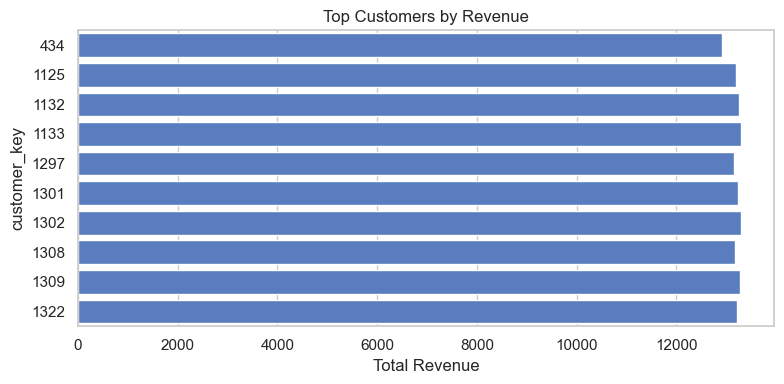

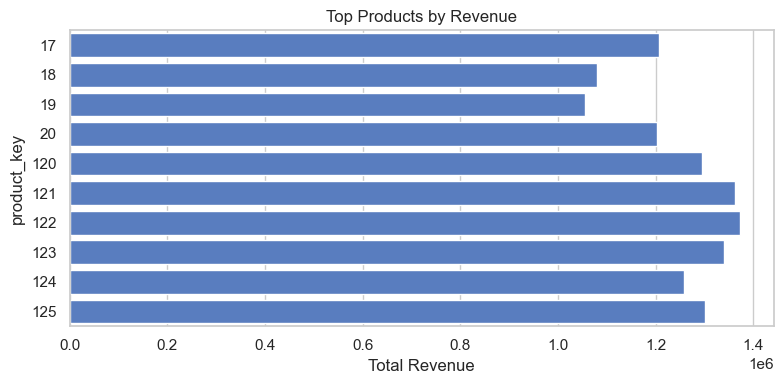

In [35]:
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 4)

# --- Revenue by Customer ---
revenue_by_customer = gold_fact_sales.groupby("customer_key")["sales_amount"].sum().sort_values(ascending=False)

print("\n=== Revenue by Customer ===")
print(revenue_by_customer.describe())
print("Top 5 customers by revenue:\n", revenue_by_customer.head())

# --- Revenue by Product ---
revenue_by_product = gold_fact_sales.groupby("product_key")["sales_amount"].sum().sort_values(ascending=False)

print("\n=== Revenue by Product ===")
print(revenue_by_product.describe())
print("Top 5 products by revenue:\n", revenue_by_product.head())

# --- Revenue by Category ---
merged = gold_fact_sales.merge(
    gold_dim_products[["product_key", "category"]],
    how="left",
    on="product_key"
)
revenue_by_category = merged.groupby("category")["sales_amount"].sum().sort_values(ascending=False)

print("\n=== Revenue by Category ===")
print(revenue_by_category)

# --- Plotting ---

def plot_revenue_series(series, title, top_n=None):
    if top_n:
        series = series.head(top_n)
    sns.barplot(x=series.values, y=series.index, orient="h")
    plt.title(title)
    plt.xlabel("Total Revenue")
    plt.tight_layout()
    plt.show()

plot_revenue_series(revenue_by_customer, "Top Customers by Revenue", top_n=10)
plot_revenue_series(revenue_by_product, "Top Products by Revenue", top_n=10)
# plot_revenue_series(revenue_by_category, "Revenue by Product Category")

## Ranking Analysis


Top 5 Customers by Revenue:
 customer_key
1133    13294
1302    13294
1309    13268
1132    13265
1301    13242
Name: sales_amount, dtype: int64

Top 5 Customers by Quantity:
 customer_key
186    68
301    67
224    65
278    65
263    63
Name: quantity, dtype: int64


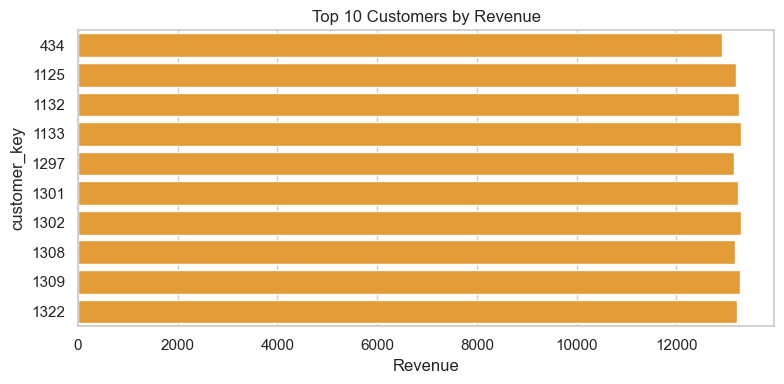

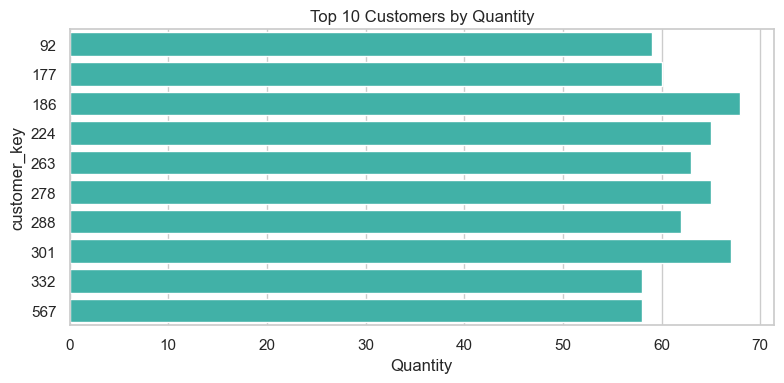


Top 5 Products by Revenue:
 product_key
122    1373454
121    1363128
123    1339394
125    1301029
120    1294854
Name: sales_amount, dtype: int64

Top 5 Products by Quantity:
 product_key
295    4249
259    3191
289    3096
290    2376
246    2230
Name: quantity, dtype: int64


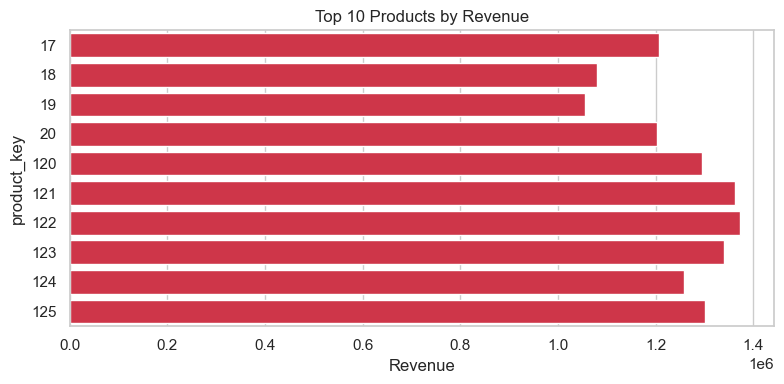

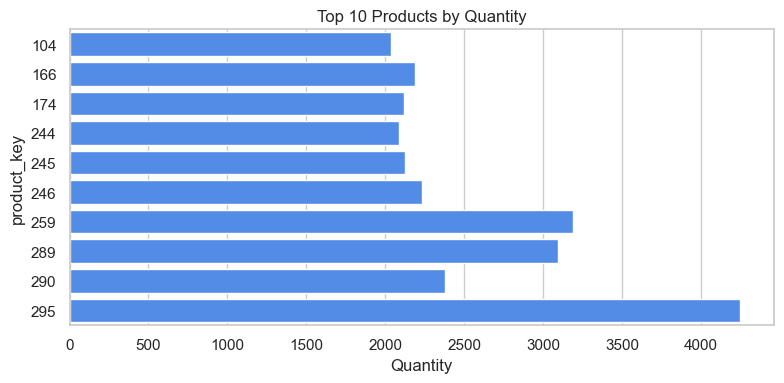

In [36]:
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (8, 4)

# Helper to plot rankings
def plot_top(series, title, top_n=10, xlabel="Total", color="steelblue"):
    top = series.sort_values(ascending=False).head(top_n)
    sns.barplot(x=top.values, y=top.index, orient="h", color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

# --- Customers ---
customer_rev = gold_fact_sales.groupby("customer_key")["sales_amount"].sum()
customer_qty = gold_fact_sales.groupby("customer_key")["quantity"].sum()

print("\nTop 5 Customers by Revenue:\n", customer_rev.sort_values(ascending=False).head())
print("\nTop 5 Customers by Quantity:\n", customer_qty.sort_values(ascending=False).head())

plot_top(customer_rev, "Top 10 Customers by Revenue", xlabel="Revenue", color="#FF9F1C")
plot_top(customer_qty, "Top 10 Customers by Quantity", xlabel="Quantity", color="#2EC4B6")

# --- Products ---
product_rev = gold_fact_sales.groupby("product_key")["sales_amount"].sum()
product_qty = gold_fact_sales.groupby("product_key")["quantity"].sum()

print("\nTop 5 Products by Revenue:\n", product_rev.sort_values(ascending=False).head())
print("\nTop 5 Products by Quantity:\n", product_qty.sort_values(ascending=False).head())

plot_top(product_rev, "Top 10 Products by Revenue", xlabel="Revenue", color="#E71D36")
plot_top(product_qty, "Top 10 Products by Quantity", xlabel="Quantity", color="#3A86FF")

# --- Categories ---
merged = gold_fact_sales.merge(
    gold_dim_products[["product_key", "category"]],
    how="left",
    on="product_key"
)
cat_rev = merged.groupby("category")["sales_amount"].sum()

# print("\nRevenue by Category:\n", cat_rev.sort_values(ascending=False))
# plot_top(cat_rev, "Revenue by Product Category", xlabel="Revenue", color="#8338EC")


# **Behavioral & Temporal Analysis**

In [37]:
date_cols = ["order_date", "shipping_date", "due_date"]
for col in date_cols:
    gold_fact_sales[col] = pd.to_datetime(gold_fact_sales[col], errors='coerce')

# Display min/max for each date column
print("--- Date Range Summary ---")
for col in date_cols:
    print(f"{col.title()}: {gold_fact_sales[col].min().date()} → {gold_fact_sales[col].max().date()}")


--- Date Range Summary ---
Order_Date: 2010-12-29 → 2014-01-28
Shipping_Date: 2011-01-05 → 2014-02-04
Due_Date: 2011-01-10 → 2014-02-09


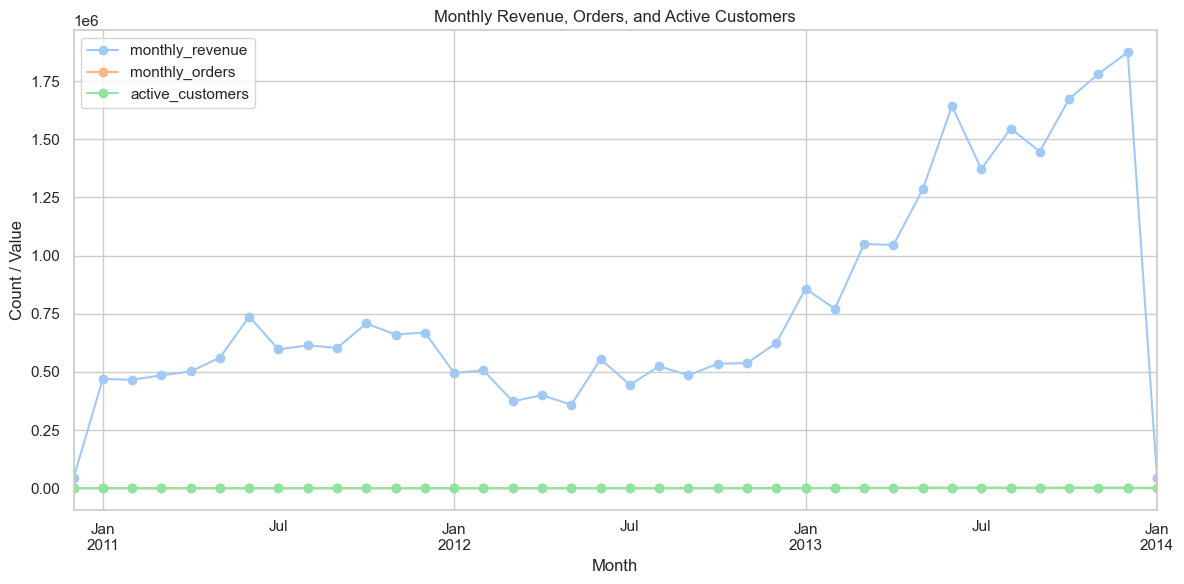

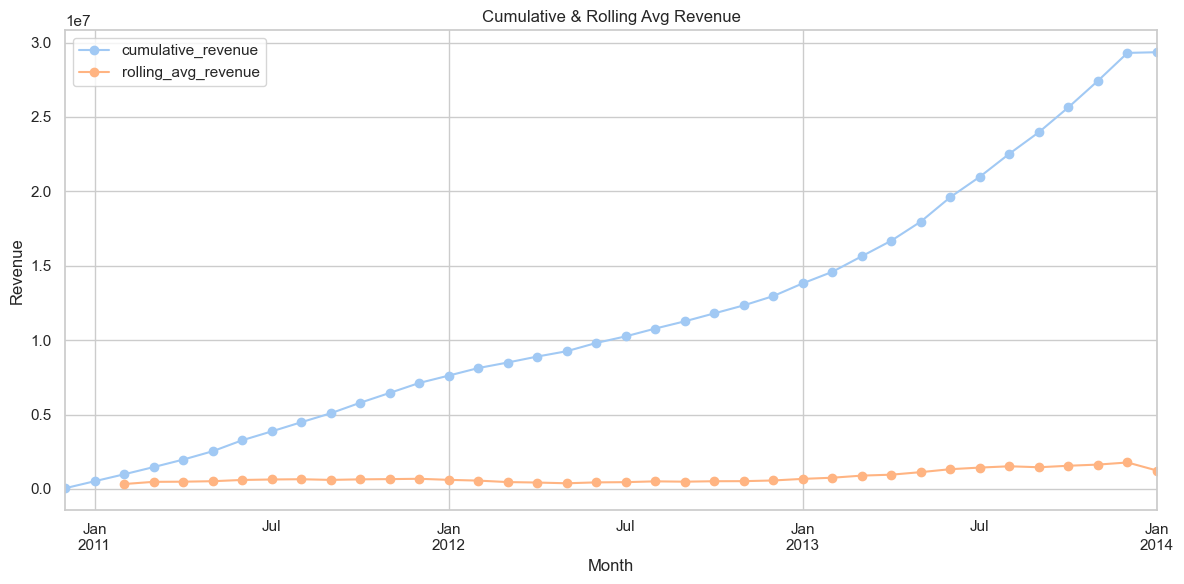

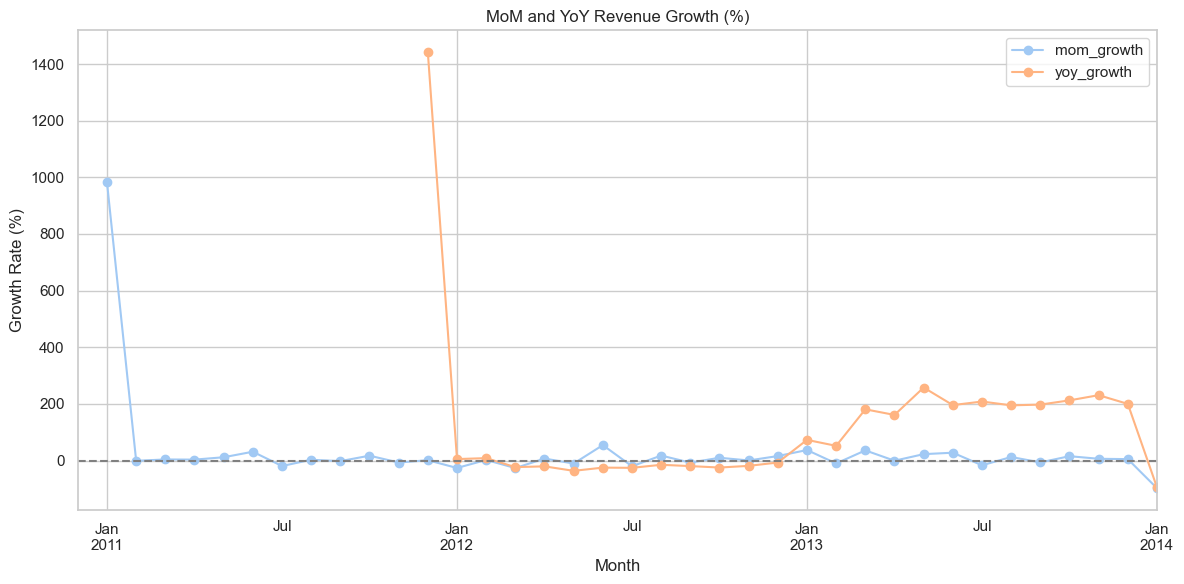


Top Long Lifecycle Products:
            first_sale  last_sale  total_revenue  days_active
product_key                                                  
120         2011-12-29 2013-12-28        1294854          730
124         2011-12-29 2013-12-28        1257368          730
122         2011-12-29 2013-12-27        1373454          729
139         2011-12-29 2013-12-27         628384          729
143         2011-12-29 2013-12-27         702666          729


) missing from font(s) Arial.h_2nybh6rhc0000gn/T/ipykernel_24151/2356676626.py:96: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) Arial.s/data_e/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


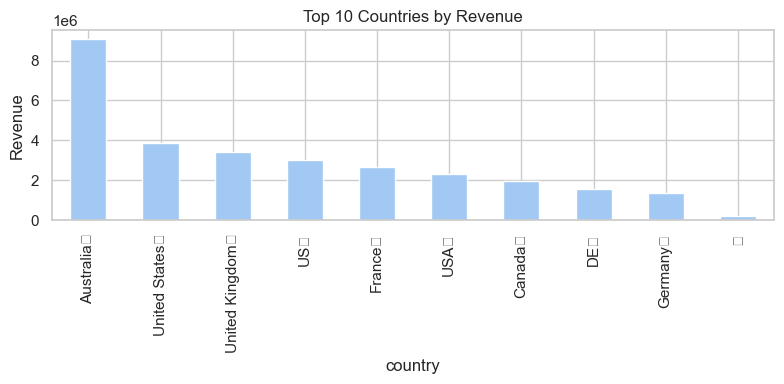

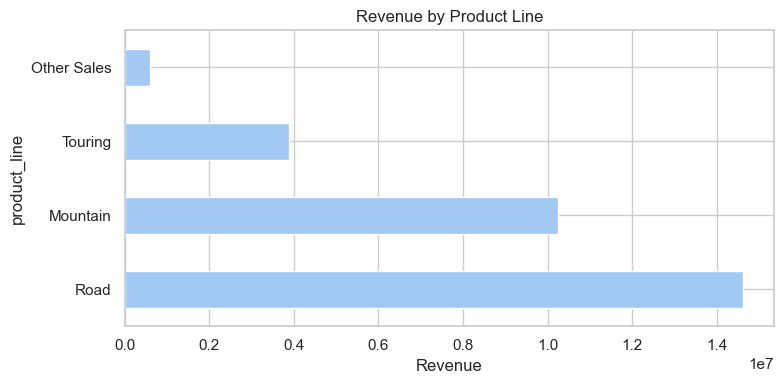

In [38]:
# Ensure order_date is datetime and add monthly period
gold_fact_sales['order_date'] = pd.to_datetime(gold_fact_sales['order_date'])
gold_fact_sales['order_month'] = gold_fact_sales['order_date'].dt.to_period('M')

# === 7. Change Over Time ===
monthly_trends = gold_fact_sales.groupby('order_month').agg({
    'sales_amount': 'sum',
    'order_number': 'nunique',
    'customer_key': 'nunique'
}).rename(columns={
    'sales_amount': 'monthly_revenue',
    'order_number': 'monthly_orders',
    'customer_key': 'active_customers'
}).reset_index()

monthly_trends['order_month'] = monthly_trends['order_month'].dt.to_timestamp()

# Plotting
monthly_trends.set_index('order_month')[['monthly_revenue', 'monthly_orders', 'active_customers']].plot(
    figsize=(12,6), marker='o', title='Monthly Revenue, Orders, and Active Customers'
)
plt.ylabel("Count / Value")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# === 8. Cumulative Metrics ===
monthly_trends['cumulative_revenue'] = monthly_trends['monthly_revenue'].cumsum()
monthly_trends['rolling_avg_revenue'] = monthly_trends['monthly_revenue'].rolling(window=3).mean()

monthly_trends.plot(x='order_month', y=['cumulative_revenue', 'rolling_avg_revenue'], figsize=(12,6), marker='o', title='Cumulative & Rolling Avg Revenue')
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# === 9. Performance Metrics ===
monthly_trends['mom_growth'] = monthly_trends['monthly_revenue'].pct_change() * 100
monthly_trends['yoy_growth'] = monthly_trends['monthly_revenue'].pct_change(periods=12) * 100

monthly_trends.plot(x='order_month', y=['mom_growth', 'yoy_growth'], figsize=(12,6), marker='o', title='MoM and YoY Revenue Growth (%)')
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

# === 10. Segmentation ===

# RFM Style Customer Segmentation
snapshot_date = gold_fact_sales['order_date'].max() + pd.Timedelta(days=1)
rfm = gold_fact_sales.groupby('customer_key').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'order_number': 'count',
    'sales_amount': 'sum'
}).rename(columns={'order_date': 'recency', 'order_number': 'frequency', 'sales_amount': 'monetary'})

rfm['value_segment'] = pd.qcut(rfm['monetary'], q=4, labels=['Low', 'Med-Low', 'Med-High', 'High'])

# Product Lifecycle Proxy
product_lifecycle = gold_fact_sales.groupby('product_key').agg(
    first_sale=('order_date', 'min'),
    last_sale=('order_date', 'max'),
    total_revenue=('sales_amount', 'sum')
)
product_lifecycle['days_active'] = (product_lifecycle['last_sale'] - product_lifecycle['first_sale']).dt.days

# Example: Show top long-lifecycle products
print("\nTop Long Lifecycle Products:")
print(product_lifecycle.sort_values(by='days_active', ascending=False).head())

# === 11. Part-to-Whole ===
# Merge product data for category and product line info
merged = gold_fact_sales.merge(
    gold_dim_products[['product_key', 'category', 'product_line']],
    on='product_key',
    how='left'
)

# # Revenue by Category
# category_share = merged.groupby('category')['sales_amount'].sum().sort_values(ascending=False)
# category_share.plot.pie(autopct='%1.1f%%', figsize=(6,6), title='Revenue Share by Category')
# plt.ylabel("")
# plt.tight_layout()
# plt.show()

# Revenue by Country
merged_cust = gold_fact_sales.merge(
    gold_dim_customers[['customer_key', 'country']],
    on='customer_key',
    how='left'
)
country_share = merged_cust.groupby('country')['sales_amount'].sum().sort_values(ascending=False).head(10)
country_share.plot.bar(title='Top 10 Countries by Revenue')
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# Revenue by Product Line
product_line_share = merged.groupby('product_line')['sales_amount'].sum().sort_values(ascending=False)
product_line_share.plot.barh(title='Revenue by Product Line')
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()

## **Summarising and exporting**


 Executive Summary
• Total Revenue: $29,356,250.00
• Total Orders: 27,659
• Unique Customers: 18,484
• Avg Order Value: $1,061.36
• Avg Revenue per Customer: $1,588.20

 Top Customers by Revenue


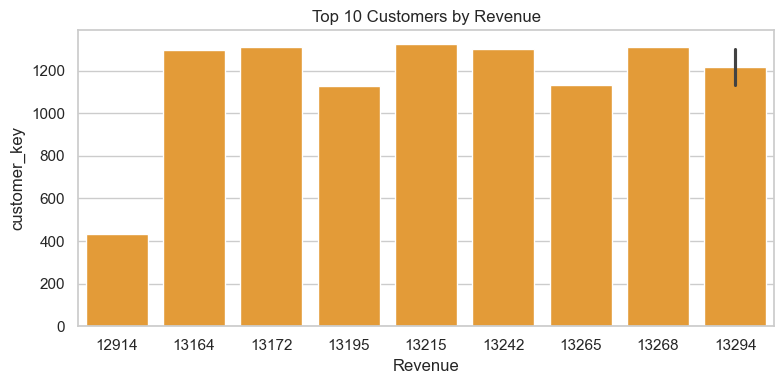


 Top Products by Revenue


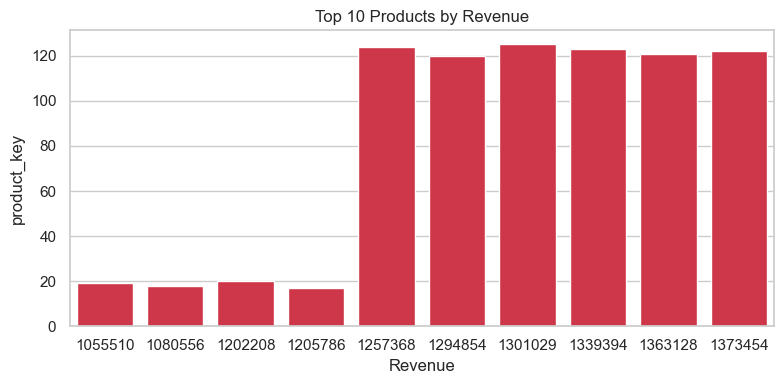


 Top Categories by Revenue


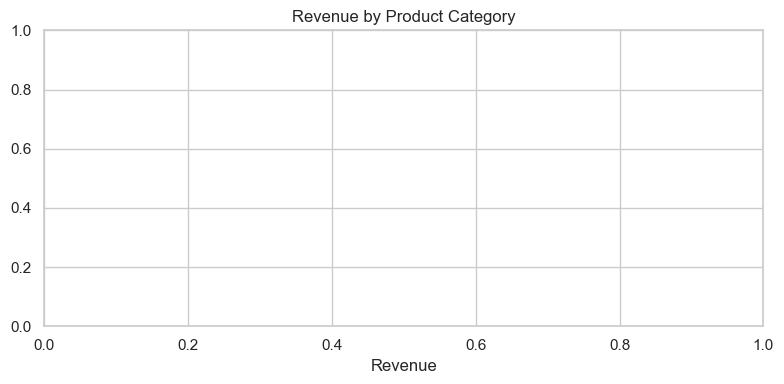


 Top Countries by Revenue


) missing from font(s) Arial.h_2nybh6rhc0000gn/T/ipykernel_24151/2534572932.py:35: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) Arial.s/data_e/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


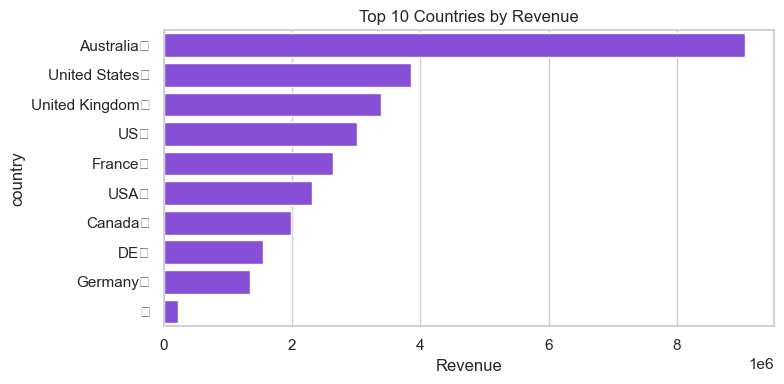

In [39]:
# --- KPIs ---
total_revenue = gold_fact_sales['sales_amount'].sum()
total_orders = gold_fact_sales['order_number'].nunique()
unique_customers = gold_fact_sales['customer_key'].nunique()
avg_order_value = gold_fact_sales.groupby('order_number')['sales_amount'].sum().mean()
avg_rev_per_customer = gold_fact_sales.groupby('customer_key')['sales_amount'].sum().mean()

print("\n Executive Summary")
print(f"• Total Revenue: ${total_revenue:,.2f}")
print(f"• Total Orders: {total_orders:,}")
print(f"• Unique Customers: {unique_customers:,}")
print(f"• Avg Order Value: ${avg_order_value:,.2f}")
print(f"• Avg Revenue per Customer: ${avg_rev_per_customer:,.2f}")

# --- Top Entities ---
top_customers = gold_fact_sales.groupby('customer_key')['sales_amount'].sum().sort_values(ascending=False).head(10)
top_products = gold_fact_sales.groupby('product_key')['sales_amount'].sum().sort_values(ascending=False).head(10)

# Merge for categories and countries
cat_rev = gold_fact_sales.merge(gold_dim_products[['product_key', 'category']], on='product_key', how='left')
cust_rev = gold_fact_sales.merge(gold_dim_customers[['customer_key', 'country']], on='customer_key', how='left')

top_categories = cat_rev.groupby('category')['sales_amount'].sum().sort_values(ascending=False)
top_countries = cust_rev.groupby('country')['sales_amount'].sum().sort_values(ascending=False).head(10)

# --- Plotting ---
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (8, 4)

def plot_top(series, title, xlabel="Total", color="steelblue", top_n=10):
    series = series.sort_values(ascending=False).head(top_n)
    sns.barplot(x=series.values, y=series.index, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

print("\n Top Customers by Revenue")
plot_top(top_customers, "Top 10 Customers by Revenue", "Revenue", "#FF9F1C")

print("\n Top Products by Revenue")
plot_top(top_products, "Top 10 Products by Revenue", "Revenue", "#E71D36")

print("\n Top Categories by Revenue")
plot_top(top_categories, "Revenue by Product Category", "Revenue", "#3A86FF")

print("\n Top Countries by Revenue")
plot_top(top_countries, "Top 10 Countries by Revenue", "Revenue", "#8338EC")